In [1]:
from utils import (
    cluster_reader,
    intersection,
    partition_graph,
    random_partition_graph,
    build_graph
)
import itertools
from dataset import OGBNDataset
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import math
from collections import Counter
from copy import deepcopy
from torch_geometric.data import ClusterData

In [3]:
dataset = OGBNDataset()
data = dataset.whole_graph

dataset\init_node_features_mean.pt exists


In [4]:
data

Data(num_nodes=132534, edge_index=[2, 79122504], edge_attr=[79122504, 8], node_species=[132534, 1], y=[132534, 112])

# Original Leiden clustering (Comparison number of edge for different algorithm)

In [11]:
leiden_edge_nums = []
metis_edge_nums = []
random_edge_nums = []
metis_clusters = []
for i in range(5):
    # Leiden
    orig_leiden_coms = cluster_reader(f"dataset/leiden_clusters_{i}.csv")
    leiden_edge_nums.append(sum(data.subgraph(torch.tensor(c)).edge_index.shape[1] for c in orig_leiden_coms))

    # Random
    random_parts = random_partition_graph(dataset.total_no_of_nodes, cluster_number=len(orig_leiden_coms))
    random_edge_nums.append(sum(data.subgraph(torch.tensor(c)).edge_index.shape[1] for c in random_parts))

    # Metis
    cluster_data = ClusterData(data, num_parts=len(orig_leiden_coms), recursive=True)
    parts = []
    idx_part = cluster_data.partptr
    for i in range(len(cluster_data)):
        parts.append(cluster_data.perm[idx_part[i]:idx_part[i+1]].tolist())
    metis_edge_nums.append(sum(data.subgraph(torch.tensor(c)).edge_index.shape[1] for c in parts))
    metis_clusters.append(parts)


print(leiden_edge_nums)
print(metis_edge_nums)
print(random_edge_nums)

F:\Thesis\Graph_Clustering\venv\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!


[66120380, 66223422, 66099570, 66104514, 66101678]
[50815516, 50815516, 50815516, 50815516, 50815516]
[3598584, 3597032, 3592762, 3598062, 3597056]


# Custom Leiden with constraint

In [5]:
class Args:
    def __init__(self, cluster_type='random', cluster_number=20, clusters_path='dataset/leiden_clusters_80_100_weight_final.csv', overlap=0, overlap_ratio=0.0):
        self.cluster_type = cluster_type
        self.cluster_number = cluster_number
        self.clusters_path = clusters_path
        self.overlap = overlap
        self.overlap_ratio = overlap_ratio

In [8]:
random_coms = partition_graph(dataset, Args())
leiden_coms = partition_graph(dataset, Args(cluster_type='leiden', clusters_path='dataset/leiden_clusters_80_100_weight_final.csv', overlap=0))
leiden_coms_overlap = partition_graph(dataset, Args(cluster_type='leiden_species', clusters_path='dataset/leiden_clusters_80_100_weight_final.csv', overlap_ratio=0.5))

print(f"Average edge in random clusters: {sum(data.subgraph(torch.tensor(c)).edge_index.shape[1] for c in random_coms)/len(random_coms):.4f}")
print(f"Average edge in leiden clusters: {sum(data.subgraph(torch.tensor(c)).edge_index.shape[1] for c in leiden_coms)/len(leiden_coms):.4f}")
print(f"Average edge in leiden overlap clusters: {sum(data.subgraph(torch.tensor(c)).edge_index.shape[1] for c in leiden_coms_overlap)/len(leiden_coms_overlap):.4f}")
print()
print("Number of nodes in dataset: ", sum(len(c) for c in random_coms))
print(f"Random: {sum(len(c) for c in random_coms)}")
print(f"Leiden: {sum(len(c) for c in leiden_coms)}")
print(f"Leiden overlap: {sum(len(c) for c in leiden_coms_overlap)}")

Average edge in random clusters: 197885.9000
Average edge in leiden clusters: 423617.0000
Average edge in leiden overlap clusters: 581229.9000

Number of nodes in dataset:  132534
Random: 132534
Leiden: 132534
Leiden overlap: 148994


# Modularity comparison

In [9]:
graph = build_graph(root='./dataset')

Building vertices: 100%|██████████| 132534/132534 [00:00<00:00, 1581765.86it/s]


Build ogbn-proteins igraph in 62.8230 seconds


In [10]:
def cluster_to_membership(clusters):
    members = [0] * len(set(c for C in clusters for c in C))
    for idx, cluster in enumerate(clusters):
        for n in cluster:
            members[n] = idx
    return members

In [12]:
orig_lei_coms = cluster_reader(r"dataset/leiden_clusters_0.csv")
leiden_coms_80_100 = cluster_reader(r"dataset/leiden_clusters_80_100_weight_final.csv")
leiden_coms_150_200 = cluster_reader(r"dataset/leiden_clusters_150_200_weight_final.csv")
leiden_coms_200_300 = cluster_reader(r"dataset/leiden_clusters_200_300_weight_final.csv")
leiden_coms_400_500 = cluster_reader(r"dataset/leiden_clusters_400_500_final.csv")
metis_coms_modularity_test = cluster_reader(r"dataset/metis_clusters_1400_bisection.csv")

In [13]:
# Leiden original
modularity0 = graph.modularity(cluster_to_membership(orig_lei_coms), weights=graph.es['weight'])
# Leiden with min/max constraint
modularity_80_100 = graph.modularity(cluster_to_membership(leiden_coms_80_100), weights=graph.es['weight'])
modularity_150_200 = graph.modularity(cluster_to_membership(leiden_coms_150_200), weights=graph.es['weight'])
modularity_200_300 = graph.modularity(cluster_to_membership(leiden_coms_200_300), weights=graph.es['weight'])
modularity_400_500 = graph.modularity(cluster_to_membership(leiden_coms_400_500), weights=graph.es['weight'])
modularity_ct_metis = graph.modularity(cluster_to_membership(metis_coms_modularity_test), weights=graph.es['weight'])

print("No constraint: ", modularity0)
print("Leiden 80-100: ", modularity_80_100)
print("Leiden 150-200: ", modularity_150_200)
print("Leiden 200-300: ", modularity_200_300)
print("Leiden 400-500: ", modularity_400_500)
print("Metis: ", modularity_ct_metis)

No constraint:  0.7321337287991091
Leiden 80-100:  0.09024661339546707
Leiden 150-200:  0.13173031982100372
Leiden 200-300:  0.18143729364319647
Leiden 400-500:  0.19769391531596428
Metis:  0.08049441068285032


In [16]:
random_coms = partition_graph(dataset, Args())
modularity_random = graph.modularity(cluster_to_membership(random_coms), weights=graph.es['weight'])
print(np.around(modularity_random, 8))  # -0.00003675

-2.557e-05


# Community size across batches (Leiden with min/max constraint)

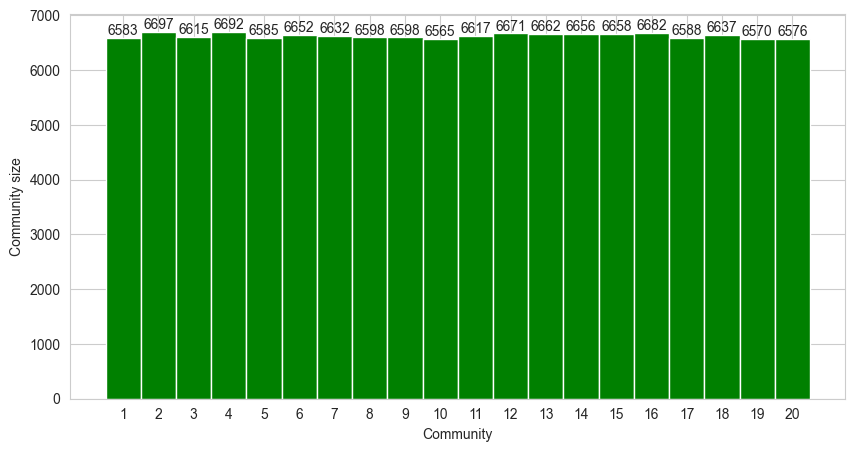

In [19]:
histogram = [len(c) for c in leiden_coms]

plt.figure(figsize=(10,5))
bar_plot = plt.bar(torch.arange(len(histogram)), histogram, color='g', width=1)
plt.bar_label(bar_plot)
plt.xlabel(f"Community")
plt.ylabel("Community size")
plt.xticks(torch.arange(len(histogram)), torch.arange(len(histogram)).numpy()+1)
# plt.title("Community size extracted by the Leiden algorithm", weight='bold', color='b')
plt.show()

# *Node species histogram*

In [20]:
def node_species_histogram(data, clusters):
    histograms = []
    for cluster in clusters:
        cluster_species = data.node_species[cluster]
        histogram = np.histogram(cluster_species.numpy(), bins=[0]+(data.node_species.unique()+1).tolist())
        histograms.append(histogram[0])
    return np.array(histograms)

def histogram_plot(histograms, xticks, label="Histogram", color='g', xlabel="Node species"):
    fig, ax = plt.subplots(nrows=math.ceil(len(histograms)/4), ncols=4, figsize=(25, 5*math.ceil(len(histograms)/5)))
    ax = ax.flatten()

    for idx, histogram in enumerate(histograms):
        bar_plot = ax[idx].bar(torch.arange(len(xticks)), histogram, label=label, color=color)
        ax[idx].bar_label(bar_plot)
        ax[idx].legend()
        ax[idx].set_xlabel(f"{xlabel}_Cluster_{idx+1}")
        ax[idx].set_ylabel("Count")
        ax[idx].set_xticks(torch.arange(len(xticks)), torch.arange(len(xticks)).numpy()+1)

    for idx in range(len(histograms), len(ax)):
        ax[idx].remove()

    fig.suptitle(f"{xlabel}_{label}", fontsize=20, weight='bold', color='b')
    plt.show()

In [21]:
node_idx = dataset.dataset.get_idx_split()
train_idx, valid_idx, test_idx = node_idx['train'], node_idx['valid'], node_idx['test']

In [22]:
print(f"All node species:\n\t {data.node_species.unique().tolist()}")
print(f"Training species:\n\t {data.node_species[train_idx].unique().tolist()}")
print(f"Validation species:\n\t {data.node_species[valid_idx].unique().tolist()}")
print(f"Test species:\n\t {data.node_species[test_idx].unique().tolist()}")

All node species:
	 [3702, 4932, 6239, 7227, 7955, 9606, 10090, 511145]
Training species:
	 [3702, 4932, 6239, 7227, 9606, 511145]
Validation species:
	 [10090]
Test species:
	 [7955]


In [23]:
all_histograms = node_species_histogram(data, [[torch.arange(data.y.shape[0])]])

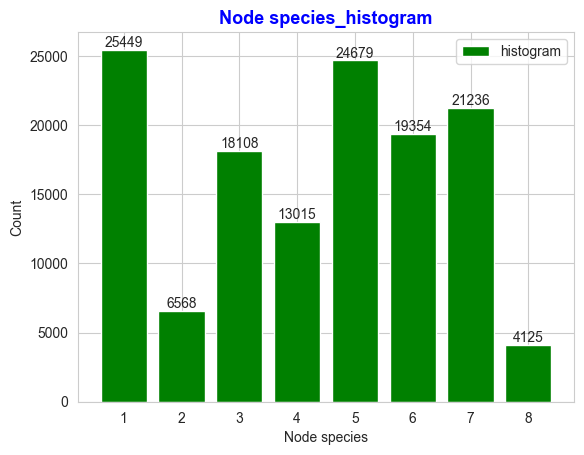

In [24]:
bar_plot = plt.bar(torch.arange(len(data.node_species.unique())), all_histograms[0], label='histogram', color='g')
plt.bar_label(bar_plot)
plt.legend()
plt.xlabel(f"Node species")
plt.ylabel("Count")
plt.xticks(torch.arange(len(data.node_species.unique())), torch.arange(len(data.node_species.unique())).numpy()+1)

plt.title(f"Node species_histogram", fontsize=13, weight='bold', color='b')
plt.show()

### Leiden clustering

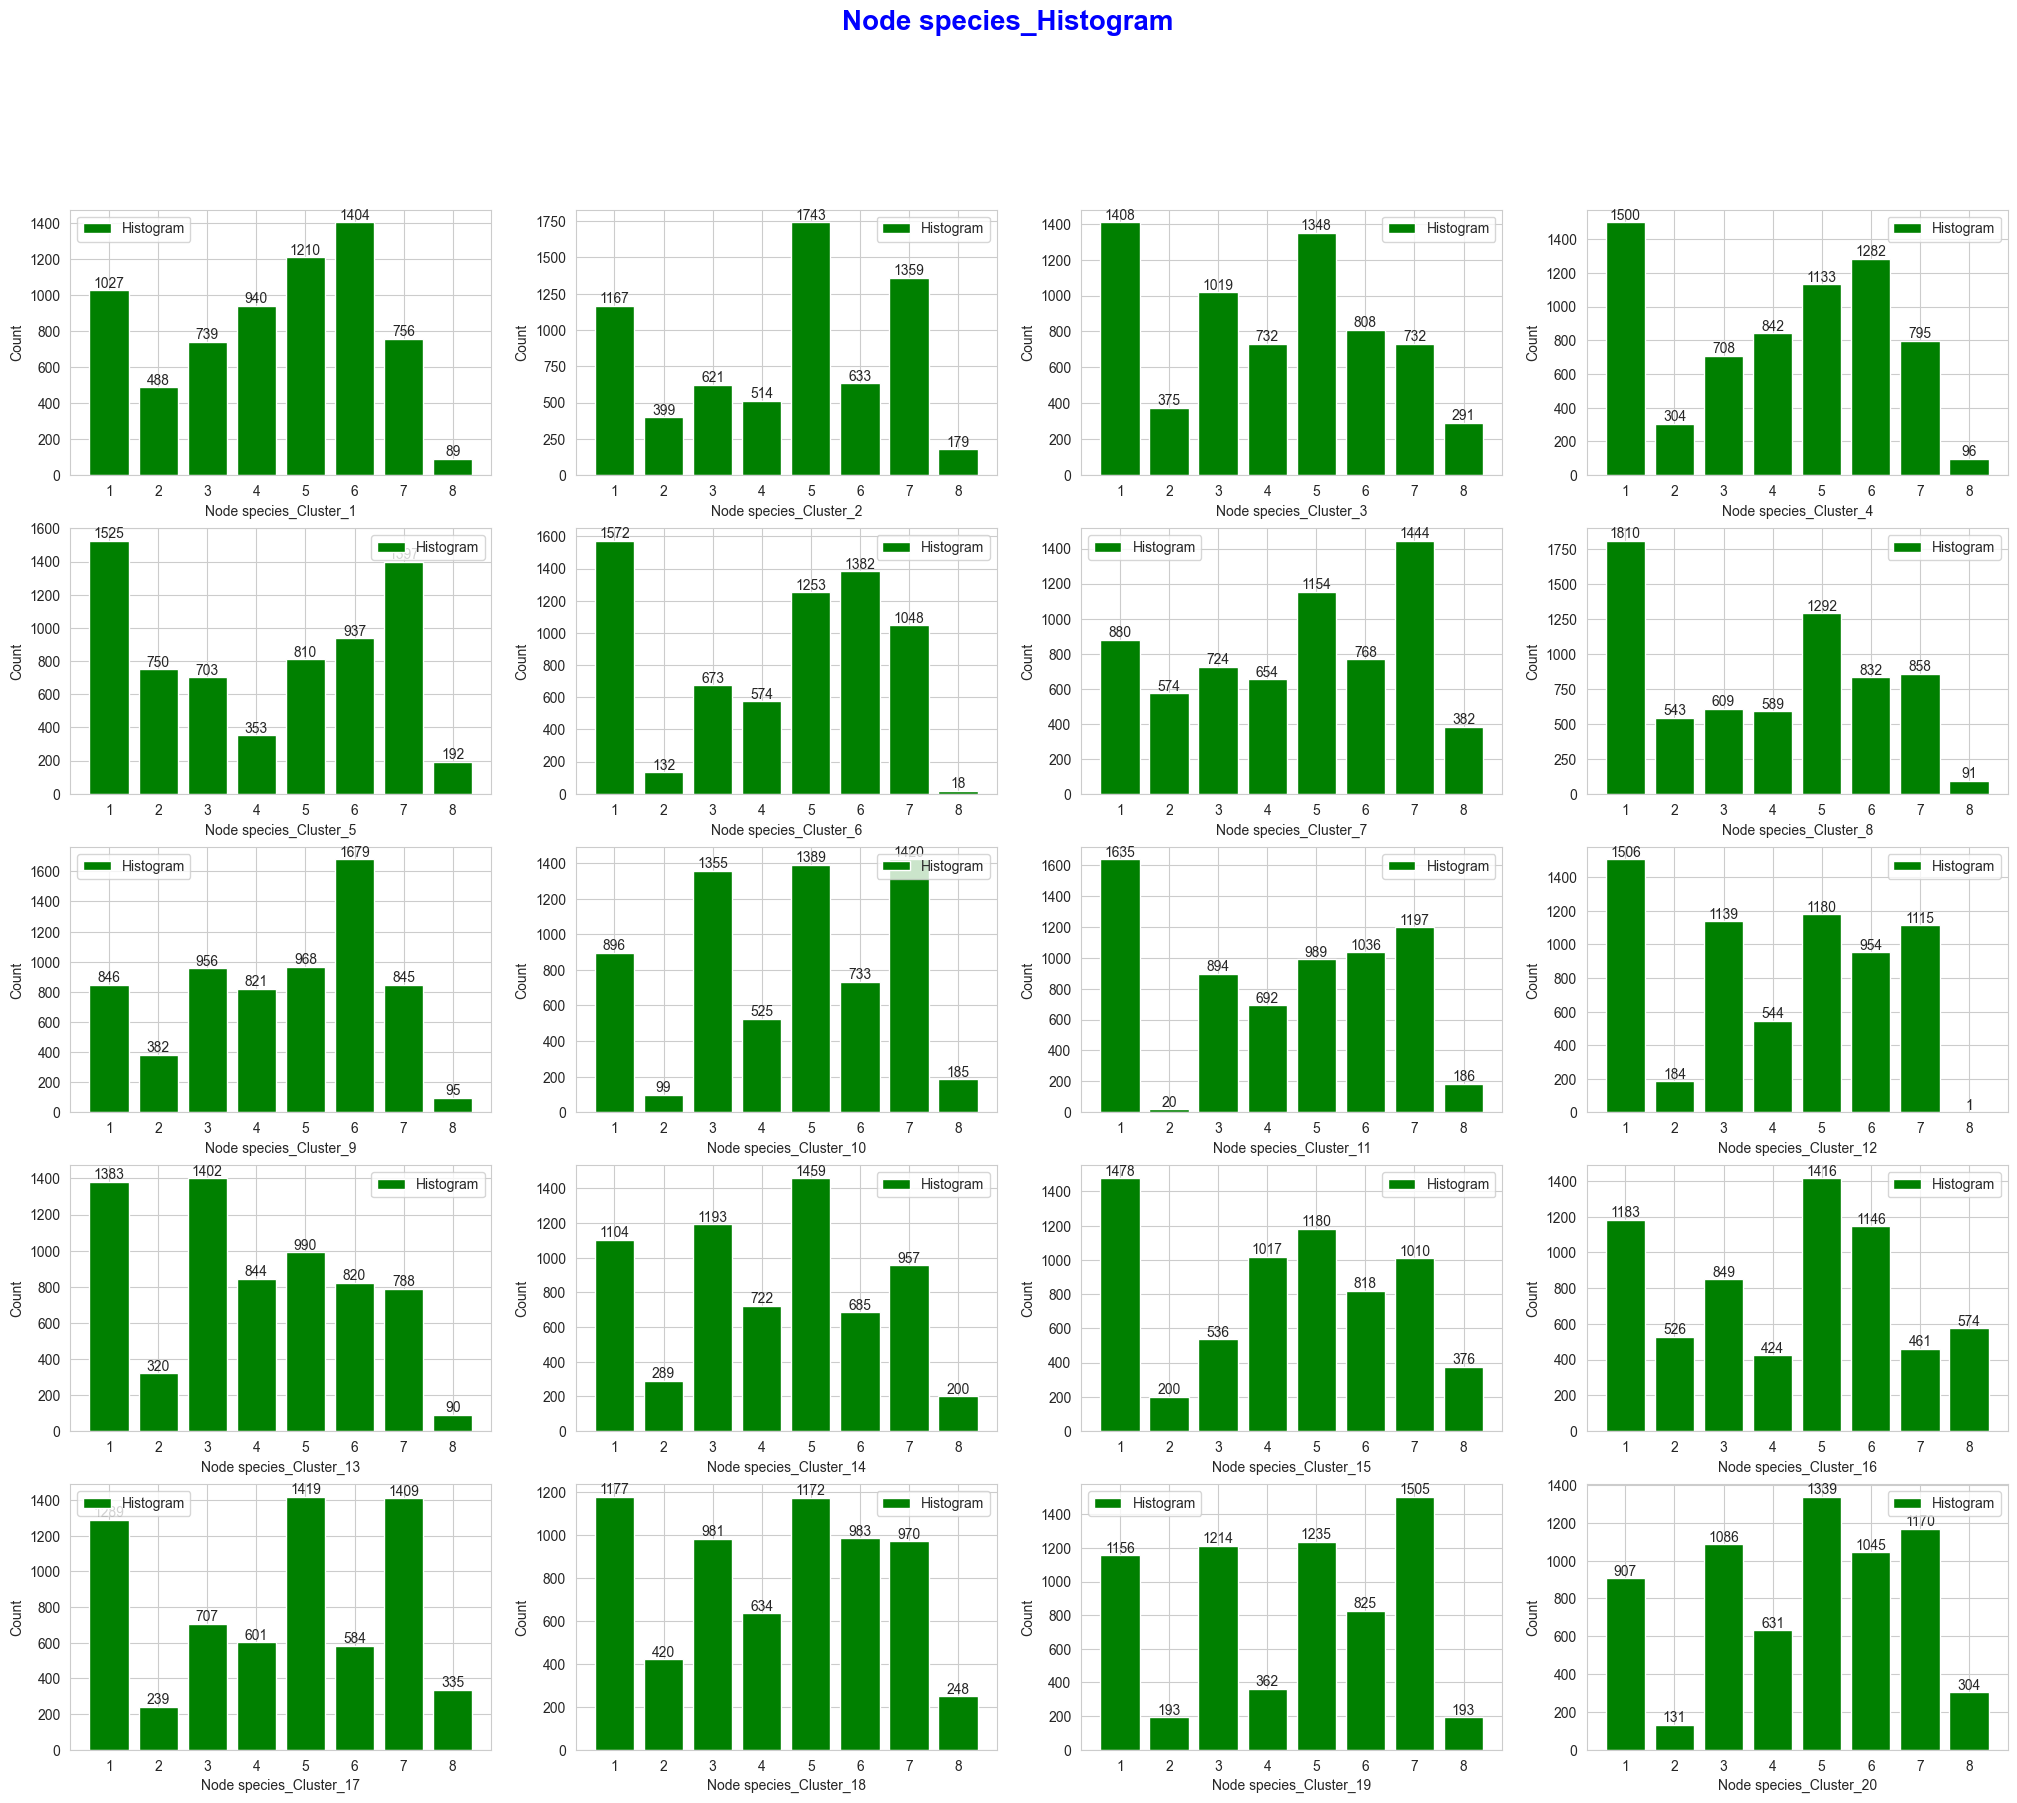

In [15]:
leiden_histograms = node_species_histogram(data, leiden_coms)
histogram_plot(leiden_histograms, data.node_species.unique())

### Random clustering

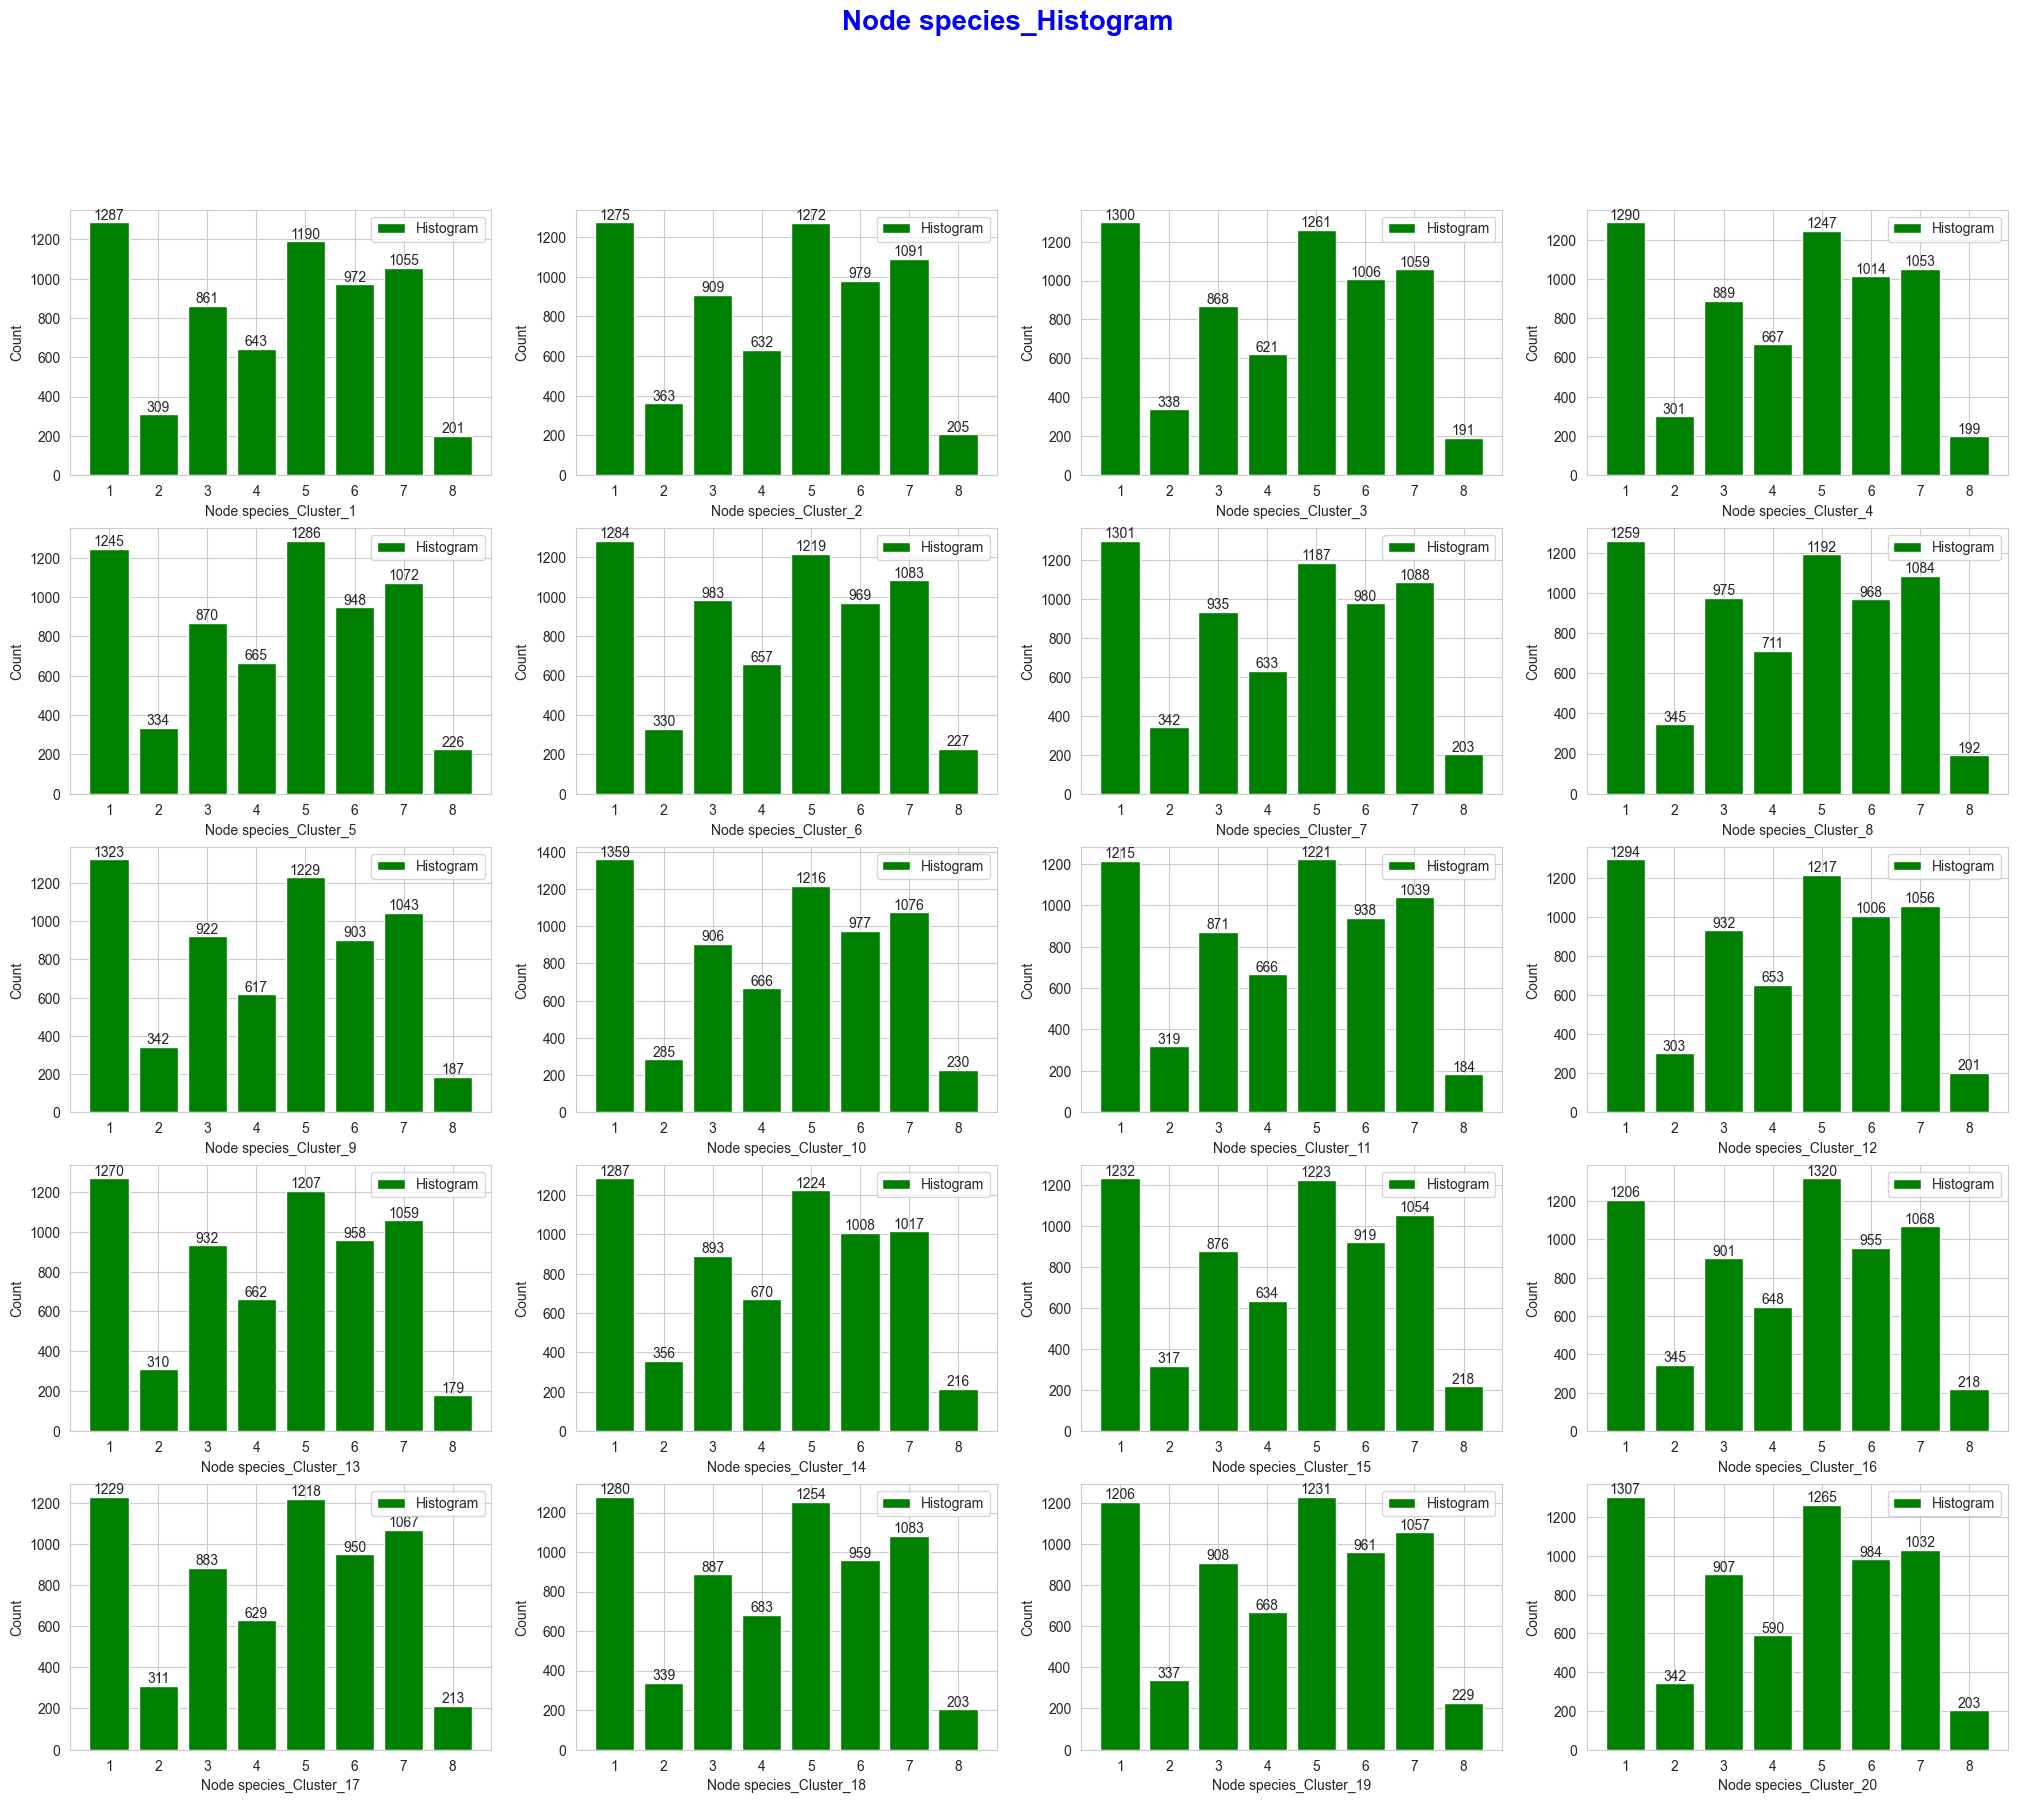

In [25]:
random_histograms = node_species_histogram(data, random_coms)
histogram_plot(random_histograms, data.node_species.unique())

### Overlap leiden

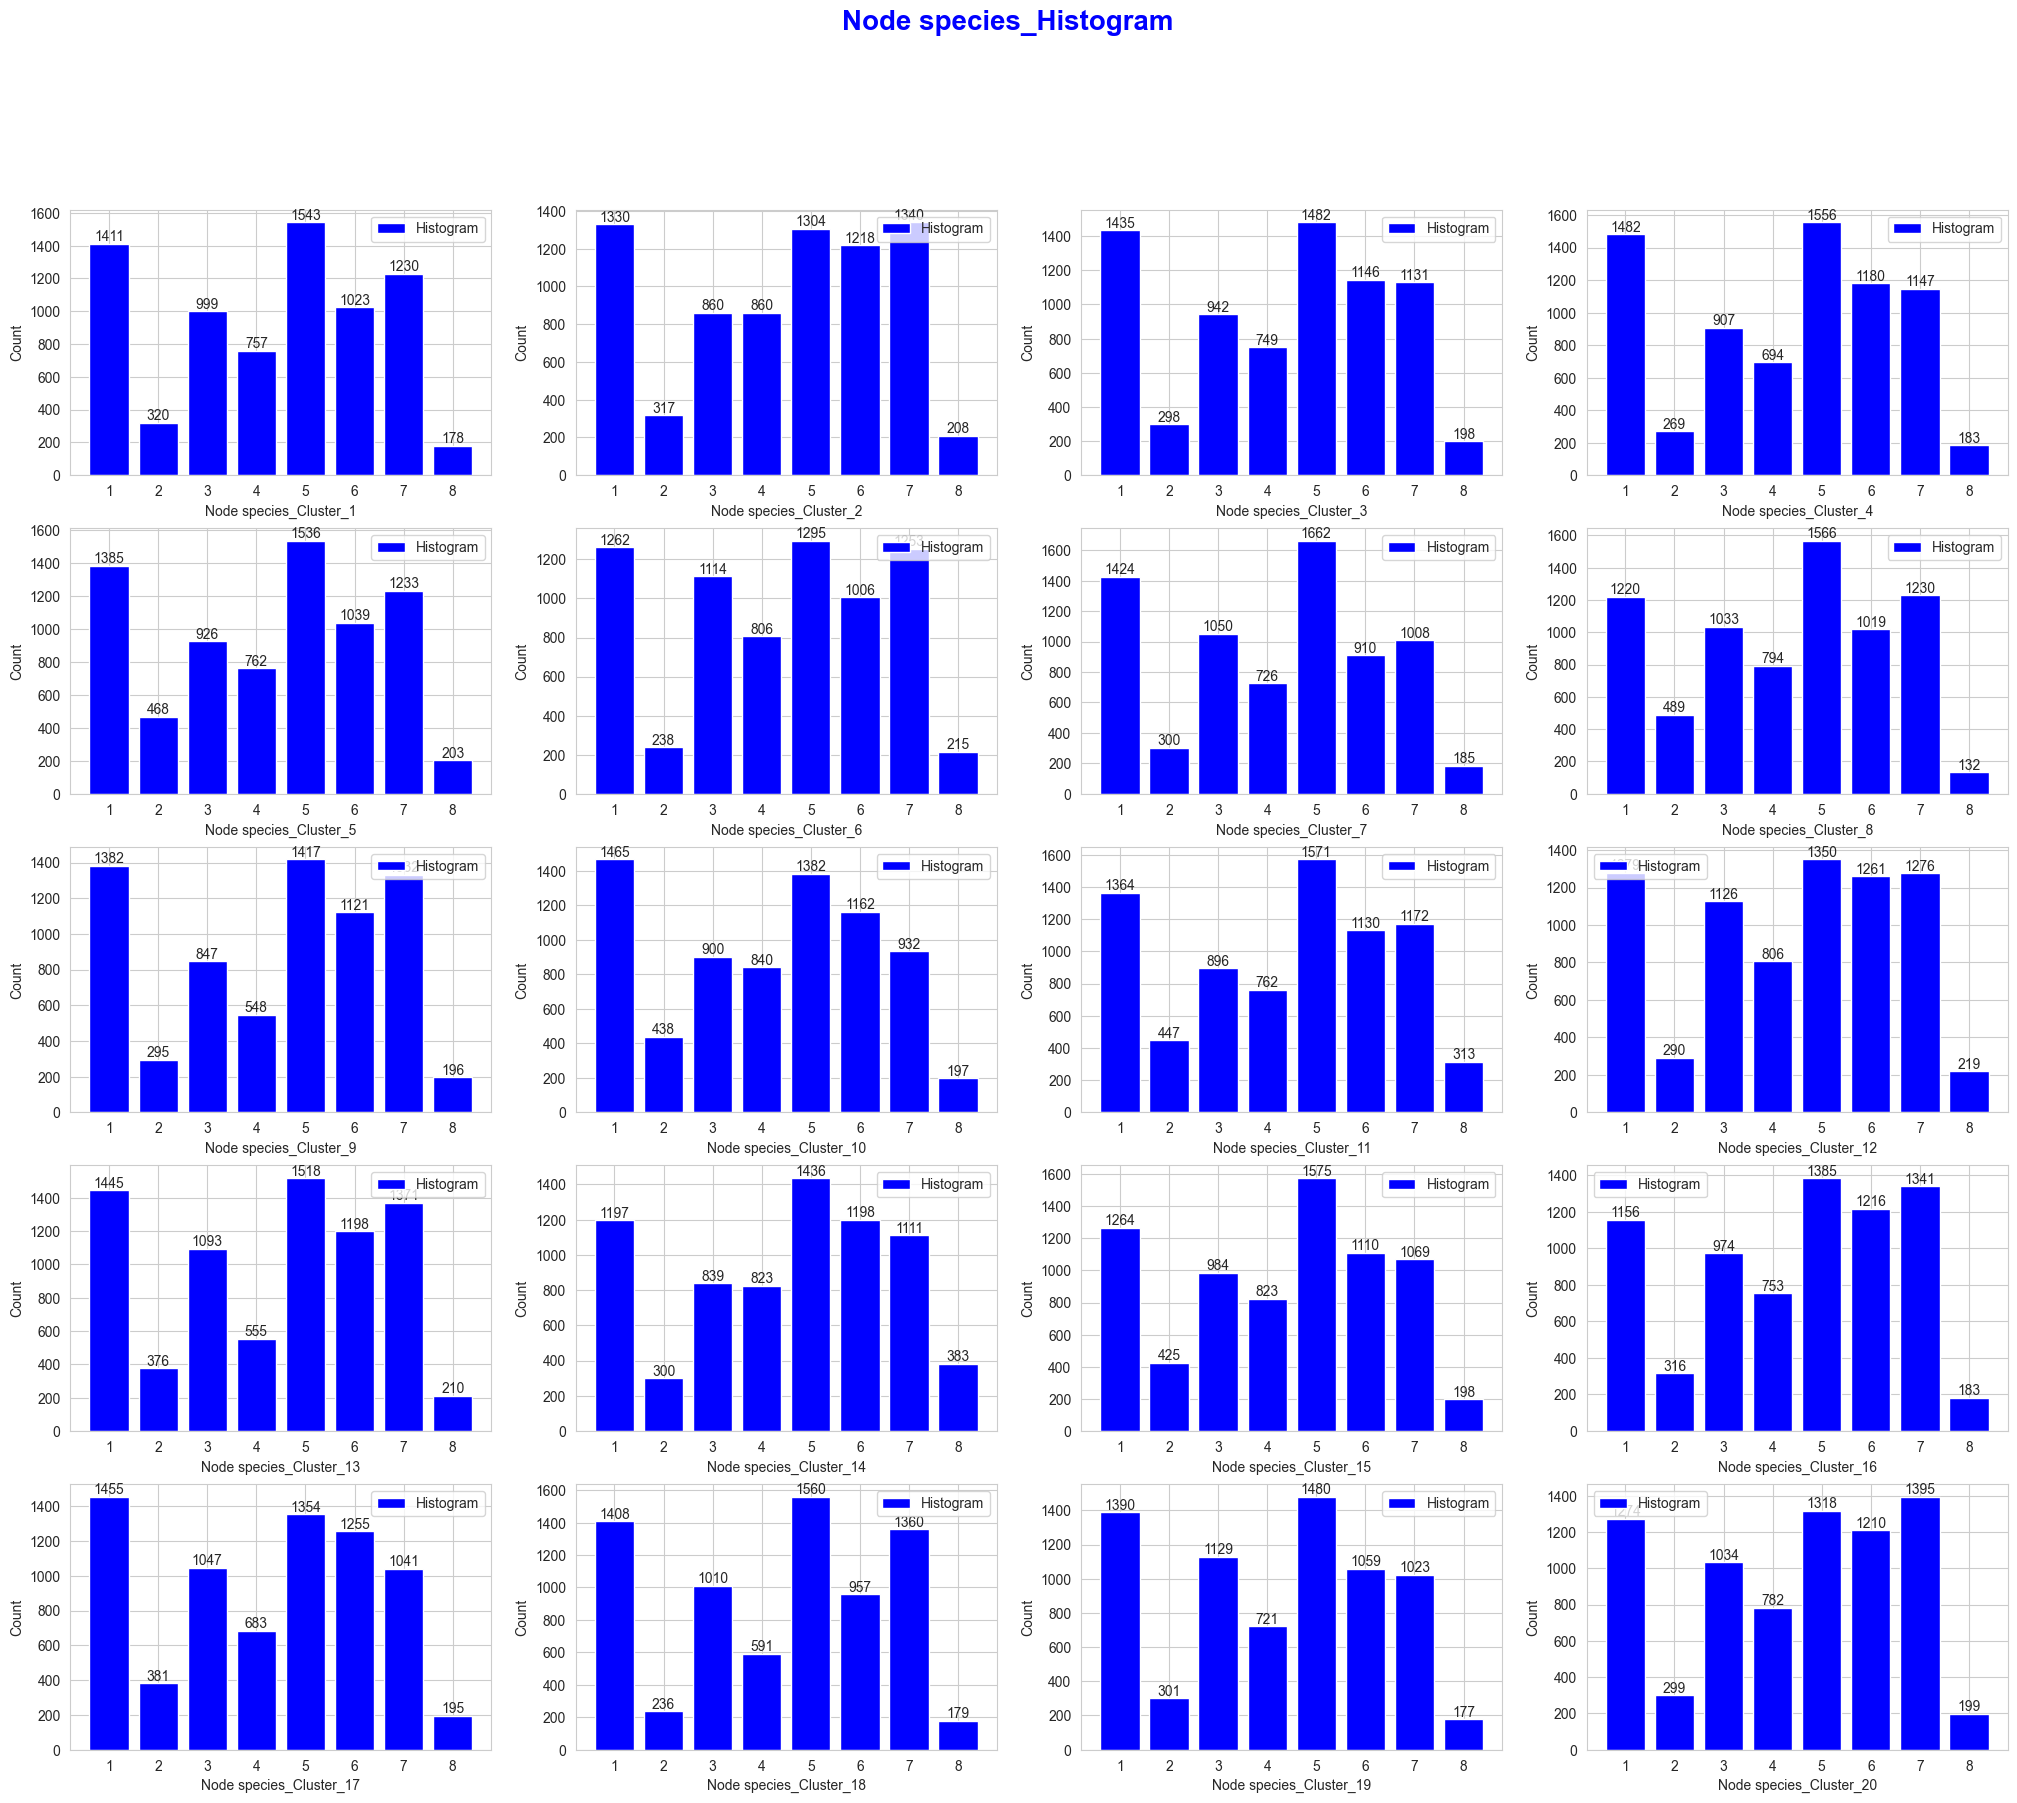

In [69]:
overlap_histograms = node_species_histogram(data, leiden_coms_overlap)
histogram_plot(overlap_histograms, data.node_species.unique(), color='b')

### Species clustering approach

In [70]:
all_coms_leiden = cluster_reader(r"dataset/leiden_clusters_80_100_weight_final.csv")
print(len(all_coms_leiden))

1400


In [73]:
for idx in range(len(all_coms_leiden)):
    all_coms_leiden[idx] = np.array(all_coms_leiden[idx])

coms_by_species = [[] for _ in range(data.node_species.unique().shape[0])]
mapping_species = {species.item(): idx for idx, species in enumerate(data.node_species.unique())}
node_species = data.node_species
for com in all_coms_leiden:
    com_species = node_species[com].squeeze().tolist()
    max_cnt_com = Counter(com_species).most_common(3)
    for com_most_species in max_cnt_com:
        if com_most_species[1]/max_cnt_com[0][1] > 0.3:
            com_to_idx = mapping_species[com_most_species[0]]
            coms_by_species[com_to_idx].append(com)

for species_coms in coms_by_species:
    print(len(species_coms), end=' ')

305 73 222 154 337 265 288 45 

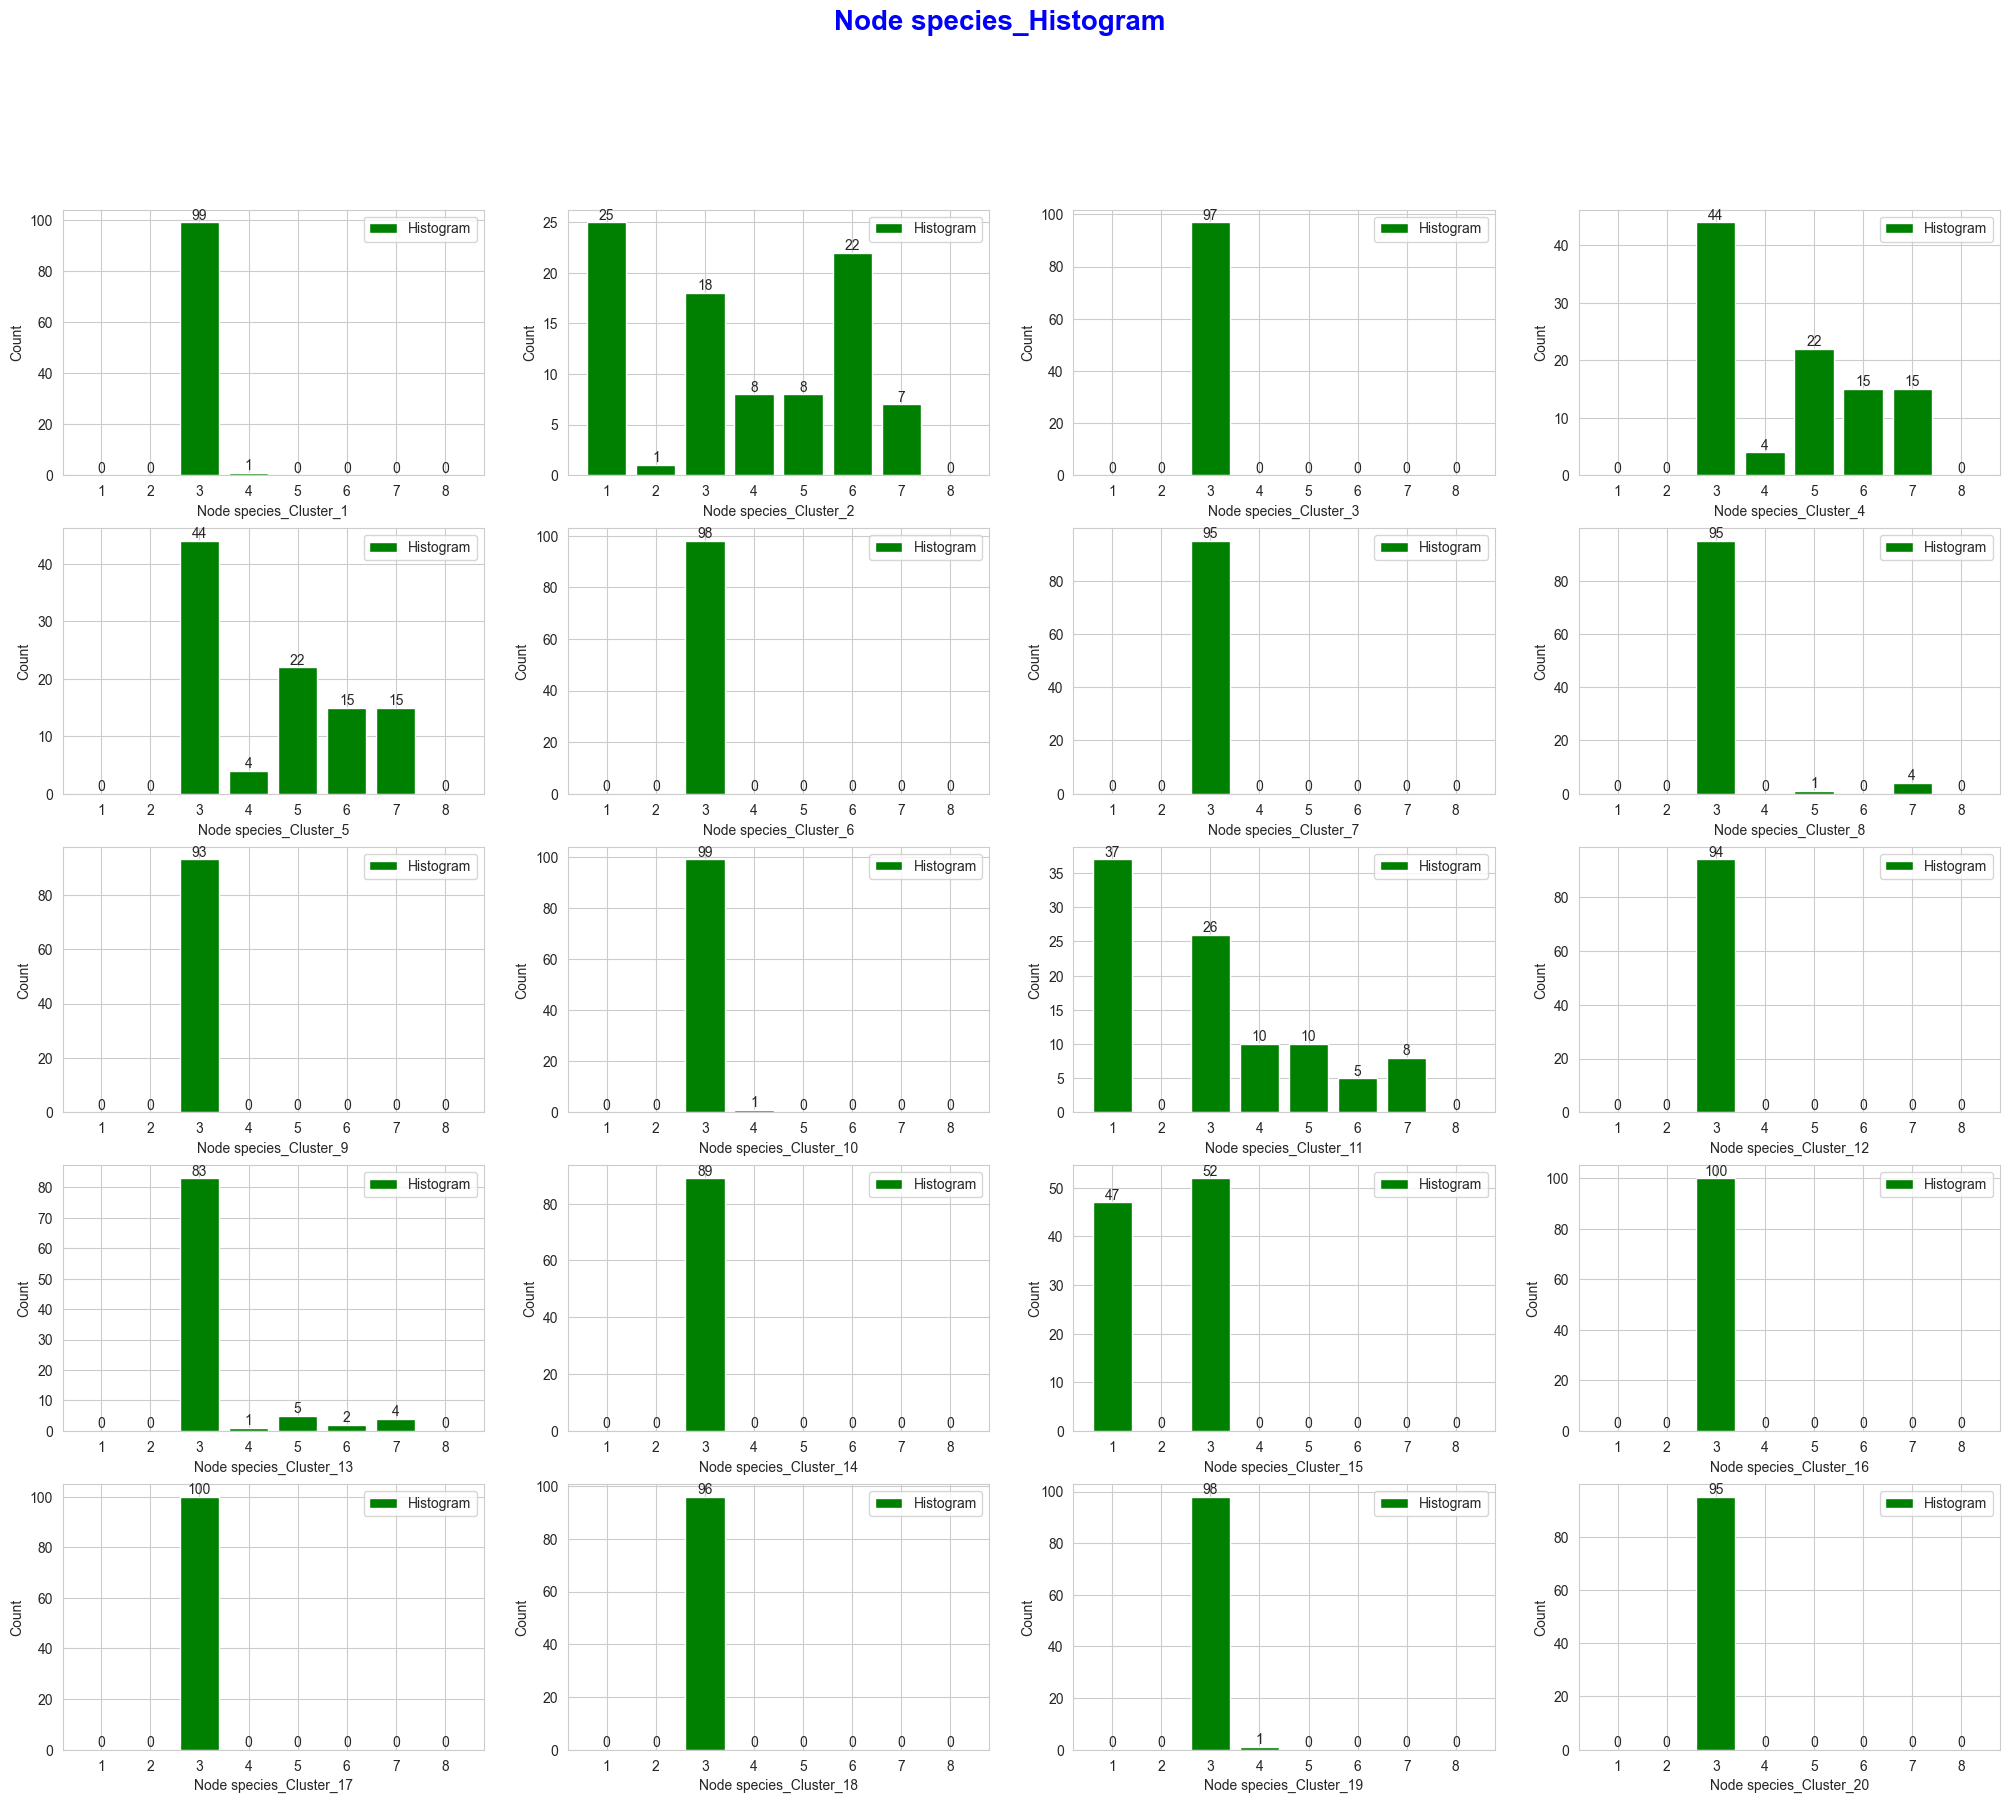

In [85]:
rd_idx = np.random.randint(len(coms_by_species[-1]), size=20)

tmp_histogram = node_species_histogram(data, coms_by_species[-7])
histogram_plot(tmp_histogram[rd_idx], data.node_species.unique())

# **Entropy label distribution**

In [ ]:
from math import log, e


def entropy2(labels, base=None):
  """ Computes entropy of label distribution. """

  n_labels = len(labels)

  if n_labels <= 1:
    return 0

  value,counts = np.unique(labels, return_counts=True)
  probs = counts / n_labels
  n_classes = np.count_nonzero(probs)

  if n_classes <= 1:
    return 0

  ent = 0.

  # Compute entropy
  base = e if base is None else base
  for i in probs:
    ent -= i * log(i, base)

  return ent

In [ ]:
def label_entropy(list_clusters, base=None):
    entropy_list = []
    for clusters in list_clusters:
        for cluster in clusters:
            total_en = 0
            for label in range(data.y[cluster].shape[1]):
                # print(data.y[cluster][:, label].shape)
                total_en += entropy2(data.y[cluster][:, label], base)
            entropy_list.append(total_en/112)
    return entropy_list

In [ ]:
random_entropy = label_entropy(random_coms, 2)
leiden_entropy = label_entropy(leiden_coms, 2)

In [ ]:
hist_rd = np.histogram(random_entropy)
hist_ld = np.histogram(leiden_entropy)
plt.bar(hist_rd[1][:-1], hist_rd[0], width=0.01)
plt.bar(hist_ld[1][:-1], hist_ld[0], width=0.01)
# plt.xlim(left=-1, right=1)
plt.show()

In [ ]:
np.array(random_entropy).mean()

# **Label distribution**

In [47]:
import seaborn as sns

def label_distribution(data, coms):
    data_label = data.y
    label_by_coms = [data_label[c].squeeze() for c in coms]
    distributions = []
    for each_coms in label_by_coms:
        label_cnt = torch.sum(each_coms, dim=0)
        total_label = torch.sum(each_coms)
        coms_distribution = label_cnt / total_label
        distributions.append(coms_distribution.numpy())
    return np.array(distributions)

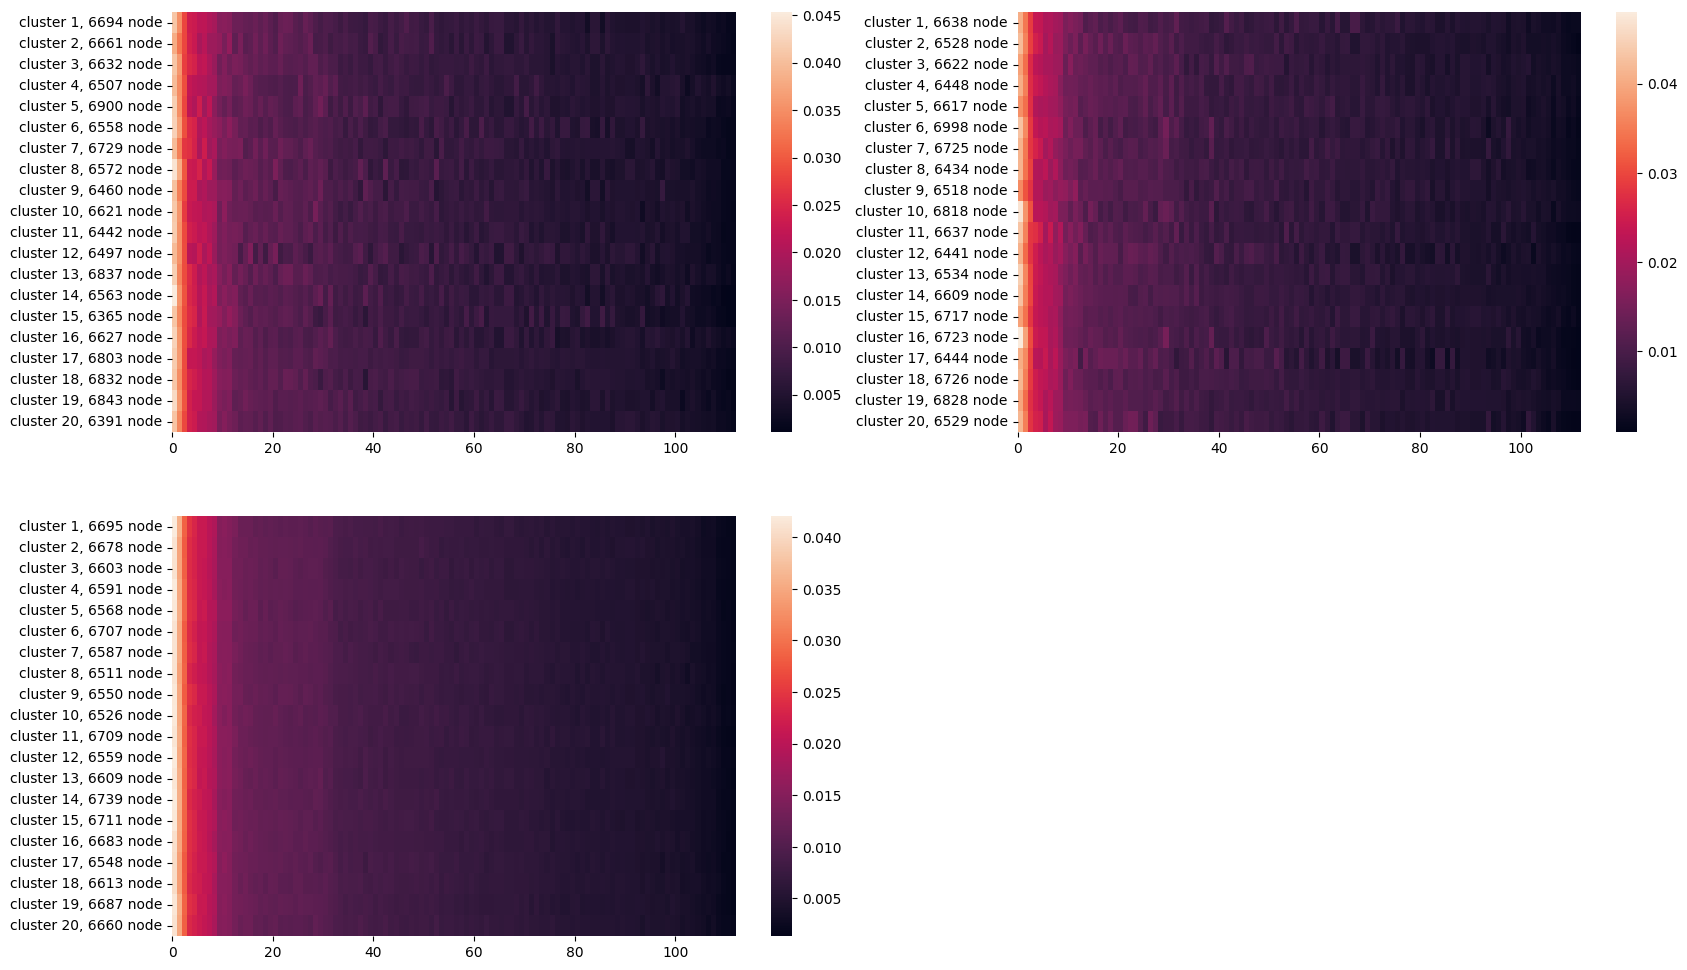

In [132]:
leiden_coms_overlap = partition_graph(dataset, Args(cluster_type='leiden_species', clusters_path='dataset/leiden_clusters_80_100_weight_final.csv', overlap_ratio=0.0))
metis_coms_overlap = partition_graph(dataset, Args(cluster_type='leiden_species', clusters_path='dataset/metis_clusters_1400_bisection.csv', overlap_ratio=0.0))
random_coms = partition_graph(dataset, Args())

leiden_distribution = label_distribution(data, leiden_coms_overlap)
metis_distribution = label_distribution(data, metis_coms_overlap)
random_distribution = label_distribution(data, random_coms)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
ax = ax.flatten()
xtick = [str(i) for i in range(0, random_distribution.shape[1], 20)]

g = sns.heatmap(leiden_distribution, ax=ax[0], yticklabels=[f'cluster {i+1}, {len(leiden_coms_overlap[i])} node' for i in range(len(leiden_distribution))])
g.set_xticks([i for i in range(0, random_distribution.shape[1], 20)])
g.set_xticklabels(xtick, rotation=0)

g = sns.heatmap(metis_distribution, ax=ax[1], yticklabels=[f'cluster {i+1}, {len(metis_coms_overlap[i])} node' for i in range(len(metis_distribution))])
g.set_xticks([i for i in range(0, random_distribution.shape[1], 20)])
g.set_xticklabels(xtick, rotation=0)

g = sns.heatmap(random_distribution, ax=ax[2], yticklabels=[f'cluster {i+1}, {len(random_coms[i])} node' for i in range(len(random_distribution))])
g.set_xticks([i for i in range(0, random_distribution.shape[1], 20)])
g.set_xticklabels(xtick, rotation=0)

ax[3].remove()
plt.show()

<Axes: >

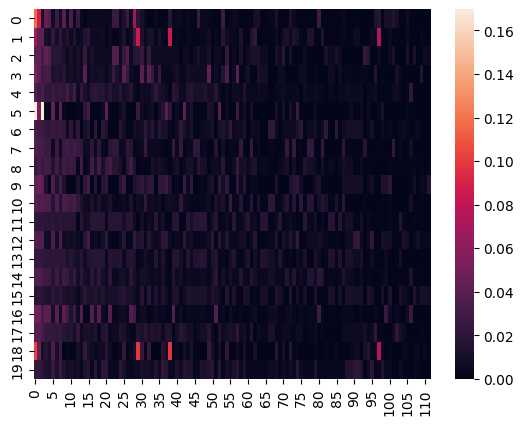

In [85]:
raw_leiden = cluster_reader('dataset/leiden_clusters_80_100_weight_final.csv')
raw_distribution =label_distribution(data, raw_leiden)

rd_idx = np.random.choice(raw_distribution.shape[0], 20, replace=False)
sns.heatmap(raw_distribution[rd_idx])